In [1]:
#  Code adapted from: https://github.com/aladdinpersson/Machine-Learning-Collection/blob/ac5dcd03a40a08a8af7e1a67ade37f28cf88db43/ML/Pytorch/GANs/2.%20DCGAN/train.py
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.utils.tensorboard.summary import hparams
import torch.nn.functional as F

import torchvision
import torchvision.transforms as tfms

import os, shutil
import math
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

Constants, etc.

In [2]:
MAP_NAME = 'map_64x64'
MAP_DIMS = (64,64)
MAX_DATA_POINTS = 100
DATA_DIR = "./logs/"                     # name of directory that TensorBoard data is saved in

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

Set hyperparams for sweep

In [3]:
parameters = dict(
    # features_gen = [32, 64, 128],
    # features_disc = [32, 64, 128],
    # noise_channels = [32, 64],
    # lr_gen = [1e-3, 1e-4, 1e-5],
    # lr_disc = [1e-6, 1e-7, 1e-8],
    # batch_size = [10, 50],
    # num_epochs = [25]
    features_gen = [32],
    features_disc = [32],
    noise_channels = [64],
    lr_gen = [1e-4],
    lr_disc = [1e-6],
    batch_size = [10],
    num_epochs = [25]
)
param_values = [v for v in parameters.values()]
total_param_runs = np.prod([len(v) for v in parameters.values()])

Prepare data-processing functions

In [4]:
transforms = tfms.Compose(
    [
        tfms.ToTensor(),
        tfms.Normalize([0.5 for _ in range(1)], [0.5 for _ in range(1)])
    ]
)

In [5]:
class Discriminator(nn.Module):
    def __init__(self, features, device='cpu'):
        super(Discriminator, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, features, kernel_size=4, stride=2, padding=1, device=device),
            nn.LeakyReLU(0.2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1, bias=False, device=device),
            nn.BatchNorm2d(features * 2, device=device),
            nn.LeakyReLU(0.2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1, bias=False, device=device),
            nn.BatchNorm2d(features * 4, device=device),
            nn.LeakyReLU(0.2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(features * 4, features * 8, kernel_size=4, stride=2, padding=1, bias=False, device=device),
            nn.BatchNorm2d(features * 8, device=device),
            nn.LeakyReLU(0.2)
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(features * 8, 1, kernel_size=4, stride=2, padding=0, device=device), # convert to single channel
            nn.AdaptiveAvgPool2d(1),    # pool the matrix into a single value for sigmoid
            nn.Sigmoid()
        )

    def forward(self, x):
        y = self.block1(x)
        y = self.block2(y)
        y = self.block3(y)
        y = self.block4(y)
        y = self.block5(y)

        return y

class Generator(nn.Module):
    def __init__(self, noise_channels, features, device='cpu'):
        super(Generator, self).__init__()

        self.block1 = nn.Sequential(
            nn.ConvTranspose2d(noise_channels, features * 16, kernel_size=4, stride=1, padding=0, device=device),
            nn.LeakyReLU(0.2)
        )

        self.block2 = nn.Sequential(
            nn.ConvTranspose2d(features * 16, features * 8, kernel_size=4, stride=2, padding=1, bias=False, device=device),
            nn.BatchNorm2d(features * 8, device=device),
            nn.LeakyReLU(0.2)
        )

        self.block3 = nn.Sequential(
            nn.ConvTranspose2d(features * 8, features * 4, kernel_size=4, stride=2, padding=1, bias=False, device=device),
            nn.BatchNorm2d(features * 4, device=device),
            nn.LeakyReLU(0.2)
        )

        self.block4 = nn.Sequential(
            nn.ConvTranspose2d(features * 4, features * 2, kernel_size=4, stride=2, padding=1, bias=False, device=device),
            nn.BatchNorm2d(features * 2, device=device),
            nn.LeakyReLU(0.2)
        )

        self.block5 = nn.Sequential(
            nn.ConvTranspose2d(features * 2, 1, kernel_size=4, stride=2, padding=1, device=device),
            nn.Tanh()
        )

    def forward(self, x, map_shape):
        y = self.block1(x)
        y = self.block2(y)
        y = self.block3(y)
        y = self.block4(y)
        y = self.block5(y)

        # y = F.adaptive_avg_pool2d(y, map_shape)
        return y

In [6]:
def noise_dims(map_dims):
    # For each convtranspose layer:
    # dim = round(math.ceil((dim + (2*padding) - kernel_size) / stride)) + 1
    # The output will need to be trimmed down to the desired size (This may hurt generalizability)
    noise_shape = []
    for i in range(len(map_dims)):
        shape = map_dims[i]

        shape = ((shape + (2*1) - 4) // 2) + 1  # Layer 5
        shape = ((shape + (2*1) - 4) // 2) + 1  # Layer 4
        shape = ((shape + (2*1) - 4) // 2) + 1  # Layer 3
        shape = ((shape + (2*1) - 4) // 2) + 1  # Layer 2
        shape = ((shape + (2*0) - 4) // 2) + 1  # Layer 1

        shape += 1  # Trim the generated paths down later
        noise_shape.append(shape)

    noise_shape = tuple(noise_shape)
    return noise_shape

# def trim(path, map_dims):
    # diff = (path.shape[0] - map_dims[0], path.shape[1] - map_dims[1])
        
    # axis_trim = (diff[0]//2, path.shape[0] - (diff[0]//2 + diff[0]%2))
    # path = path[axis_trim[0]:axis_trim[1], :]

    # axis_trim = (diff[1]//2, path.shape[1] - (diff[1]//2 + diff[1]%2))
    # path = path[:, axis_trim[0]:axis_trim[1]]

    # return path

In [ ]:
# redefining add_hparams() function in SummaryWriter class so that hyperparams are saved in a neater way
# code from https://github.com/pytorch/pytorch/issues/32651
class SummaryWriter(SummaryWriter):
    def add_hparams(self, hparam_dict, metric_dict):
        torch._C._log_api_usage_once("tensorboard.logging.add_hparams")
        if type(hparam_dict) is not dict or type(metric_dict) is not dict:
            raise TypeError('hparam_dict and metric_dict should be dictionary.')
        exp, ssi, sei = hparams(hparam_dict, metric_dict)

        logdir = self._get_file_writer().get_logdir()
        
        with SummaryWriter(log_dir=logdir) as w_hp:
            w_hp.file_writer.add_summary(exp)
            w_hp.file_writer.add_summary(ssi)
            w_hp.file_writer.add_summary(sei)
            for k, v in metric_dict.items():
                w_hp.add_scalar(k, v)

class PathsDataset(torch.utils.data.Dataset):
    def __init__(self, path, transform=None, shape = (100,100)):
        self.paths = [] # create a list to hold all paths read from file
        for filename in os.listdir(path):
            with open(os.path.join(path, filename), 'r') as f: # open in readonly mode
                self.flat_path = np.loadtxt(f) # load in the flat path from file
                self.path = np.asarray(self.flat_path, dtype=int).reshape(len(self.flat_path)//2,2) #unflatten the path from the file

                self.path_matrix = self.convert_path(shape, self.path)
                
                self.paths.append(self.path_matrix) # add the path to paths list
        self.transform = transform
        print("Done!")

    def convert_path(self, map_dim, path):
        path_mat = np.zeros(map_dim, dtype=float)

        # Make the path continuous
        for i in range(path.shape[0] - 1):
            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            if (x1 < x2):
                x_dir = 1
            else:
                x_dir = -1

            if (y1 < y2):
                y_dir = 1
            else:
                y_dir = -1

            # Determine y from x
            if x2 != x1:
                m = (y2-y1)/(x2-x1)
                while x != x2:
                    y = round(m*(x-x1) + y1)
                    path_mat[y,x] = 1
                    x += x_dir
            else:
                while x != x2:
                    path_mat[y1,x] = 1
                    x += x_dir


            x = path[i,0]
            x1 = path[i,0]
            x2 = path[i+1,0]

            y = path[i,1]
            y1 = path[i,1]
            y2 = path[i+1,1]

            # Determine x from y
            if y2 != y1:
                m = (x2-x1)/(y2-y1)
                while y != y2:
                    x = round(m*(y-y1) + x1)
                    path_mat[y,x] = 1
                    y += y_dir
            else:
                while y != y2:
                    path_mat[y,x1] = 1
                    y += y_dir
            
        path_mat[path[path.shape[0]-1,1], path[path.shape[0]-1,0]] = 1     # Include the last point in the path

        return path_mat

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        x = np.float32(self.paths[idx])

        if self.transform:
            x = self.transform(x).cuda()
            

        return x

Prepare input

In [7]:
dataset = PathsDataset(path=f'./env/{MAP_NAME}/paths/', shape=MAP_DIMS, transform=transforms)
# dataset = PathsDataset(path=f'./data/{MAP_NAME}/', shape=MAP_DIMS, transform=transforms)

NOISE_DIMS = noise_dims(MAP_DIMS)

Done!


In [8]:
# get size info --> first line of file is size
filename = f'./data/{MAP_NAME}.txt'
with open(filename) as file:
    vals = file.readline().rstrip().rsplit(' ')                 # gets string array of [size_x, size_y]
    size_x, size_y = int(vals[0]), int(vals[1])

# open and unflatten map file:
flat_map = np.loadtxt(filename, skiprows=2)             
map = np.asarray(flat_map).reshape(size_x, size_y)
# print(map)
map_obs = np.argwhere(map==1)
# np.set_printoptions(threshold=sys.maxsize)
# print(map_obs)

In [9]:
# reset data folder:
if os.path.isdir(DATA_DIR):
    shutil.rmtree(DATA_DIR)

Run [1/1] Epoch [1/25] Batch [0/2000]                         Loss D: 0.7746, loss G: 0.7105
Run [1/1] Epoch [1/25] Batch [500/2000]                         Loss D: 2.5724, loss G: 0.0095
Run [1/1] Epoch [1/25] Batch [1000/2000]                         Loss D: 2.6225, loss G: 0.0087
Run [1/1] Epoch [1/25] Batch [1500/2000]                         Loss D: 2.9403, loss G: 0.0050
Run [1/1] Epoch [2/25] Batch [0/2000]                         Loss D: 3.0914, loss G: 0.0040
Run [1/1] Epoch [2/25] Batch [500/2000]                         Loss D: 3.0404, loss G: 0.0044
Run [1/1] Epoch [2/25] Batch [1000/2000]                         Loss D: 3.0859, loss G: 0.0043
Run [1/1] Epoch [2/25] Batch [1500/2000]                         Loss D: 3.2472, loss G: 0.0034
Run [1/1] Epoch [3/25] Batch [0/2000]                         Loss D: 3.1727, loss G: 0.0041
Run [1/1] Epoch [3/25] Batch [500/2000]                         Loss D: 3.0845, loss G: 0.0052
Run [1/1] Epoch [3/25] Batch [1000/2000]            

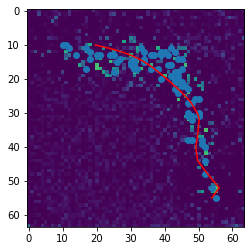

Run [1/1] Epoch [9/25] Batch [1500/2000]                         Loss D: 0.7194, loss G: 0.6825


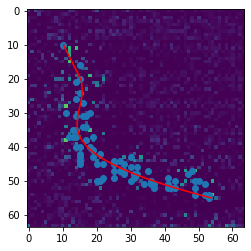

Run [1/1] Epoch [10/25] Batch [0/2000]                         Loss D: 0.7274, loss G: 0.6644


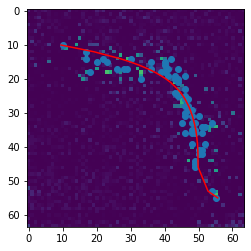

Run [1/1] Epoch [10/25] Batch [500/2000]                         Loss D: 0.6610, loss G: 0.7598


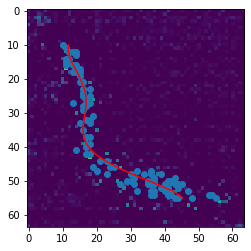

Run [1/1] Epoch [10/25] Batch [1000/2000]                         Loss D: 0.8168, loss G: 0.5789


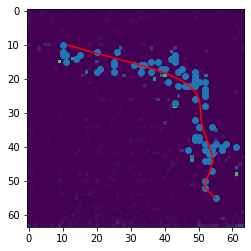

Run [1/1] Epoch [10/25] Batch [1500/2000]                         Loss D: 0.7147, loss G: 0.5605


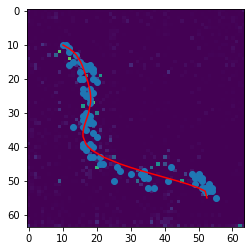

Run [1/1] Epoch [11/25] Batch [0/2000]                         Loss D: 0.6267, loss G: 0.7061
Run [1/1] Epoch [11/25] Batch [500/2000]                         Loss D: 0.5656, loss G: 0.9207


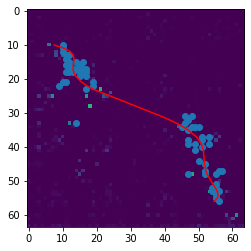

Run [1/1] Epoch [11/25] Batch [1000/2000]                         Loss D: 0.5329, loss G: 0.9250


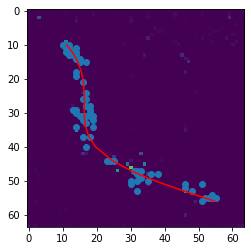

Run [1/1] Epoch [11/25] Batch [1500/2000]                         Loss D: 0.5853, loss G: 0.8252


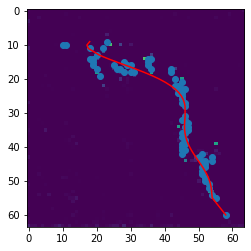

Run [1/1] Epoch [12/25] Batch [0/2000]                         Loss D: 0.6687, loss G: 0.6574


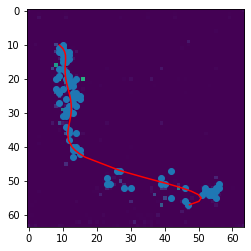

Run [1/1] Epoch [12/25] Batch [500/2000]                         Loss D: 0.6041, loss G: 0.7109


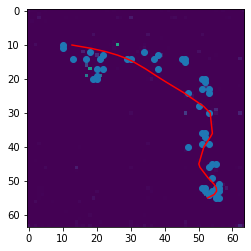

Run [1/1] Epoch [12/25] Batch [1000/2000]                         Loss D: 0.5881, loss G: 0.9145
Run [1/1] Epoch [12/25] Batch [1500/2000]                         Loss D: 0.5085, loss G: 0.9608


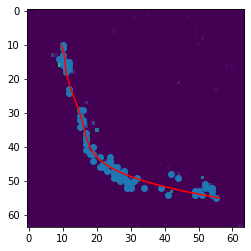

Run [1/1] Epoch [13/25] Batch [0/2000]                         Loss D: 0.5250, loss G: 0.9329


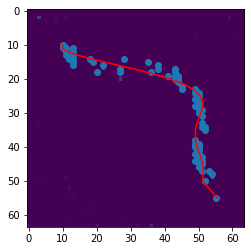

Run [1/1] Epoch [13/25] Batch [500/2000]                         Loss D: 0.6569, loss G: 0.7075


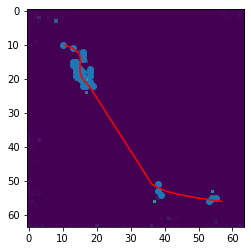

Run [1/1] Epoch [13/25] Batch [1000/2000]                         Loss D: 0.7240, loss G: 0.6359


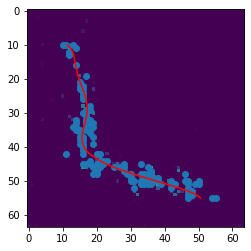

Run [1/1] Epoch [13/25] Batch [1500/2000]                         Loss D: 0.6583, loss G: 0.7450


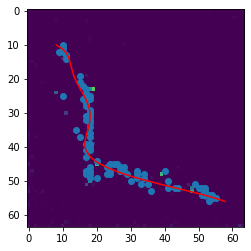

Run [1/1] Epoch [14/25] Batch [0/2000]                         Loss D: 0.6470, loss G: 0.7085


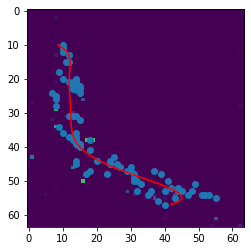

Run [1/1] Epoch [14/25] Batch [500/2000]                         Loss D: 0.6613, loss G: 0.7698


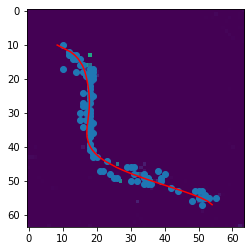

Run [1/1] Epoch [14/25] Batch [1000/2000]                         Loss D: 0.6778, loss G: 0.7164
Run [1/1] Epoch [14/25] Batch [1500/2000]                         Loss D: 0.6659, loss G: 0.7369


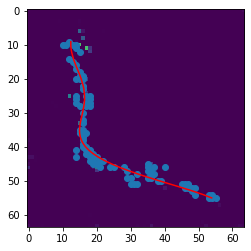

Run [1/1] Epoch [15/25] Batch [0/2000]                         Loss D: 0.6350, loss G: 0.7640


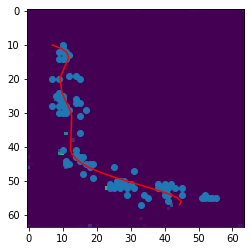

Run [1/1] Epoch [15/25] Batch [500/2000]                         Loss D: 0.6440, loss G: 0.7432


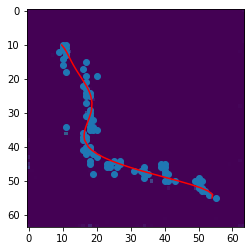

Run [1/1] Epoch [15/25] Batch [1000/2000]                         Loss D: 0.6802, loss G: 0.6873


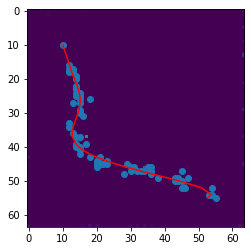

Run [1/1] Epoch [15/25] Batch [1500/2000]                         Loss D: 0.6298, loss G: 0.7827


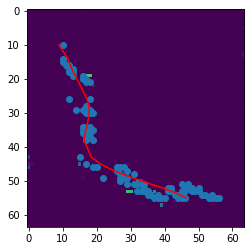

Run [1/1] Epoch [16/25] Batch [0/2000]                         Loss D: 0.6276, loss G: 0.7703


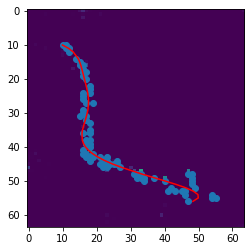

Run [1/1] Epoch [16/25] Batch [500/2000]                         Loss D: 0.6809, loss G: 0.6974


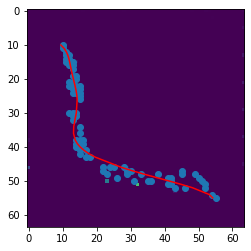

Run [1/1] Epoch [16/25] Batch [1000/2000]                         Loss D: 0.6076, loss G: 0.7749


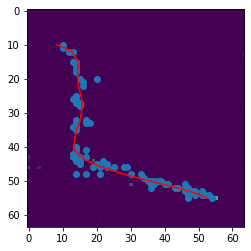

Run [1/1] Epoch [16/25] Batch [1500/2000]                         Loss D: 0.5358, loss G: 0.9415


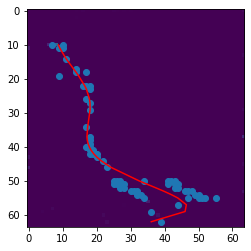

Run [1/1] Epoch [17/25] Batch [0/2000]                         Loss D: 0.6479, loss G: 0.7903


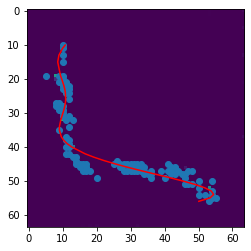

Run [1/1] Epoch [17/25] Batch [500/2000]                         Loss D: 0.6605, loss G: 0.6967


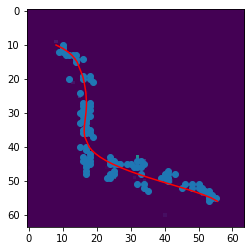

Run [1/1] Epoch [17/25] Batch [1000/2000]                         Loss D: 0.6487, loss G: 0.7125


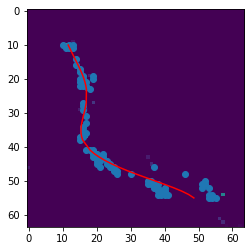

Run [1/1] Epoch [17/25] Batch [1500/2000]                         Loss D: 0.6717, loss G: 0.7093


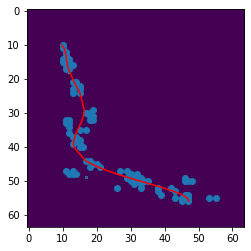

Run [1/1] Epoch [18/25] Batch [0/2000]                         Loss D: 0.5575, loss G: 0.8807


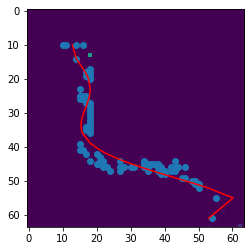

Run [1/1] Epoch [18/25] Batch [500/2000]                         Loss D: 0.6103, loss G: 0.8042


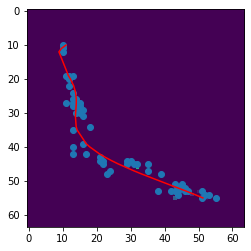

Run [1/1] Epoch [18/25] Batch [1000/2000]                         Loss D: 0.6149, loss G: 0.7872


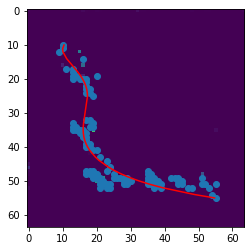

Run [1/1] Epoch [18/25] Batch [1500/2000]                         Loss D: 0.5903, loss G: 0.8534


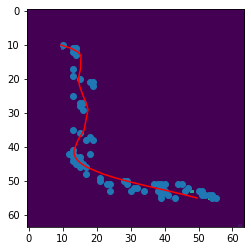

Run [1/1] Epoch [19/25] Batch [0/2000]                         Loss D: 0.6716, loss G: 0.7037


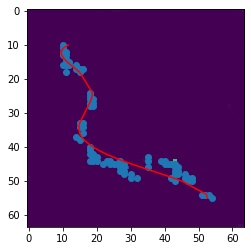

Run [1/1] Epoch [19/25] Batch [500/2000]                         Loss D: 0.4295, loss G: 1.0588


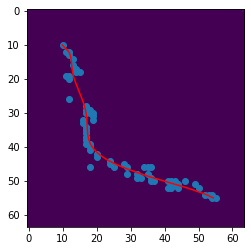

Run [1/1] Epoch [19/25] Batch [1000/2000]                         Loss D: 0.5565, loss G: 0.8504


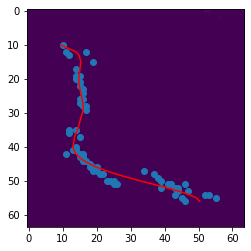

Run [1/1] Epoch [19/25] Batch [1500/2000]                         Loss D: 0.5542, loss G: 0.8542


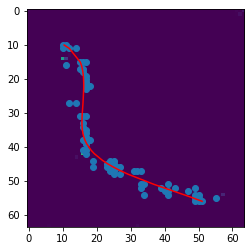

Run [1/1] Epoch [20/25] Batch [0/2000]                         Loss D: 0.7052, loss G: 0.6706


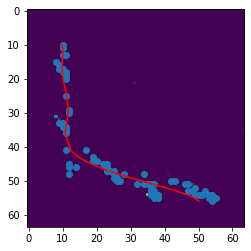

Run [1/1] Epoch [20/25] Batch [500/2000]                         Loss D: 0.6567, loss G: 0.6827
Run [1/1] Epoch [20/25] Batch [1000/2000]                         Loss D: 0.5410, loss G: 0.9217


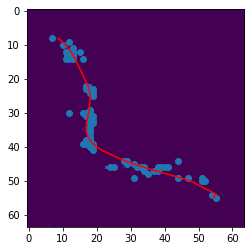

Run [1/1] Epoch [20/25] Batch [1500/2000]                         Loss D: 0.5588, loss G: 0.8950


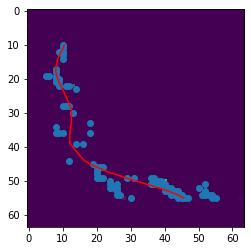

Run [1/1] Epoch [21/25] Batch [0/2000]                         Loss D: 0.5796, loss G: 0.7825


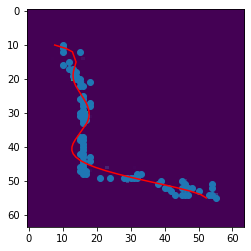

Run [1/1] Epoch [21/25] Batch [500/2000]                         Loss D: 0.5994, loss G: 0.8044


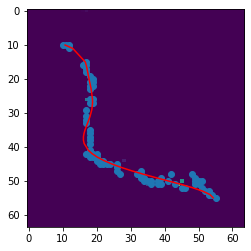

Run [1/1] Epoch [21/25] Batch [1000/2000]                         Loss D: 0.5554, loss G: 0.8822


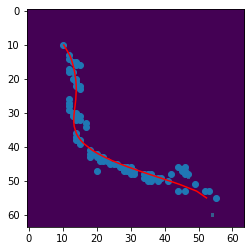

Run [1/1] Epoch [21/25] Batch [1500/2000]                         Loss D: 0.6701, loss G: 0.7614


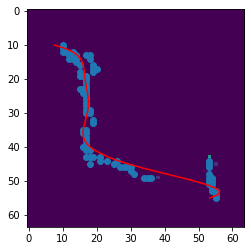

Run [1/1] Epoch [22/25] Batch [0/2000]                         Loss D: 0.7050, loss G: 0.6631


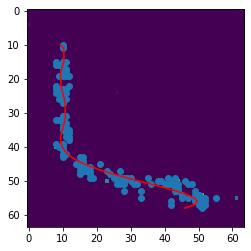

Run [1/1] Epoch [22/25] Batch [500/2000]                         Loss D: 0.5550, loss G: 0.8902


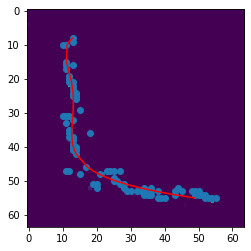

Run [1/1] Epoch [22/25] Batch [1000/2000]                         Loss D: 0.6857, loss G: 0.6989


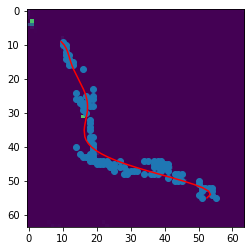

Run [1/1] Epoch [22/25] Batch [1500/2000]                         Loss D: 0.5091, loss G: 0.9002


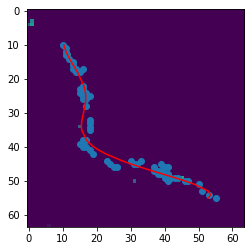

Run [1/1] Epoch [23/25] Batch [0/2000]                         Loss D: 0.5004, loss G: 0.9957


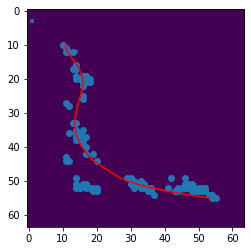

Run [1/1] Epoch [23/25] Batch [500/2000]                         Loss D: 0.5401, loss G: 0.9093


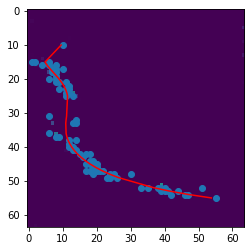

Run [1/1] Epoch [23/25] Batch [1000/2000]                         Loss D: 0.5964, loss G: 0.7579


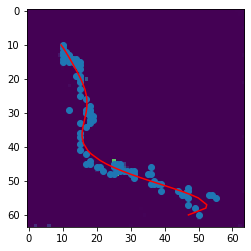

Run [1/1] Epoch [23/25] Batch [1500/2000]                         Loss D: 0.5005, loss G: 0.9644


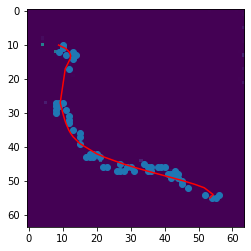

Run [1/1] Epoch [24/25] Batch [0/2000]                         Loss D: 0.5717, loss G: 0.7841


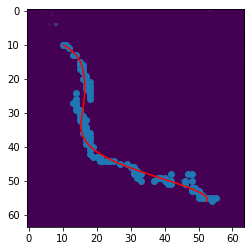

Run [1/1] Epoch [24/25] Batch [500/2000]                         Loss D: 0.5330, loss G: 0.8901


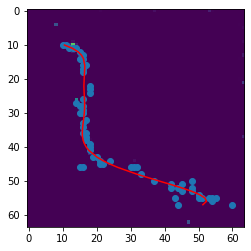

Run [1/1] Epoch [24/25] Batch [1000/2000]                         Loss D: 0.2122, loss G: 1.6359


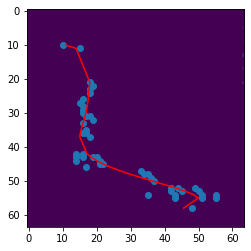

Run [1/1] Epoch [24/25] Batch [1500/2000]                         Loss D: 0.4447, loss G: 1.1476


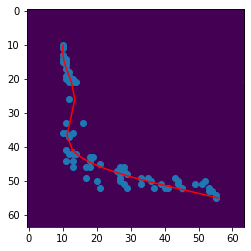

Run [1/1] Epoch [25/25] Batch [0/2000]                         Loss D: 0.5194, loss G: 0.9733


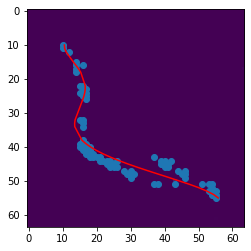

Run [1/1] Epoch [25/25] Batch [500/2000]                         Loss D: 0.4629, loss G: 1.0777


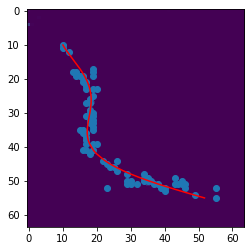

Run [1/1] Epoch [25/25] Batch [1000/2000]                         Loss D: 0.5118, loss G: 0.9326


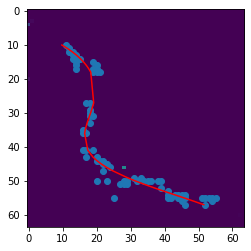

Run [1/1] Epoch [25/25] Batch [1500/2000]                         Loss D: 0.4201, loss G: 1.1009


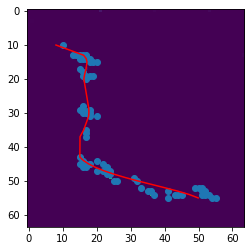

In [10]:
run_number = 0

for (features_gen, features_disc, noise_channels, lr_gen, lr_disc, batch_size, num_epochs) in product(*param_values):

    writer = SummaryWriter(f"{DATA_DIR}run{run_number}")

    disc = Discriminator(features_disc, device=DEVICE)
    gen = Generator(noise_channels, features_gen, device=DEVICE)
    fixed_noise = torch.randn((batch_size, noise_channels, NOISE_DIMS[0], NOISE_DIMS[1]), device=DEVICE)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    opt_disc = optim.Adam(disc.parameters(), lr=lr_disc)
    opt_gen = optim.Adam(gen.parameters(), lr=lr_gen)
    criterion = nn.BCELoss()

    loss_step_rate = round((len(loader)*num_epochs)/MAX_DATA_POINTS)

    step = 0
    loss_step = 0
    img_step = 0

    for epoch in range(num_epochs):
        for batch_idx, real in enumerate(loader):
            batch_size = real.shape[0]

            ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
            noise = torch.randn((batch_size, noise_channels, NOISE_DIMS[0], NOISE_DIMS[1]), device=DEVICE)
            fake = gen(noise, MAP_DIMS)
            disc_real = disc(real)
            lossD_real = criterion(disc_real, torch.ones_like(disc_real))
            disc_fake = disc(fake)
            lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
            lossD = (lossD_real + lossD_fake) / 2
            disc.zero_grad()
            lossD.backward(retain_graph=True)
            opt_disc.step()

            ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
            # where the second option of maximizing doesn't suffer from
            # saturating gradients
            output = disc(fake)
            lossG = criterion(output, torch.ones_like(output))
            gen.zero_grad()
            lossG.backward()
            opt_gen.step()

            if step % loss_step_rate == 0:              # save loss values at pre-determined rate
                # saving loss
                writer.add_scalar(f"Discriminator Loss", lossD, loss_step)
                writer.add_scalar(f"Generator Loss", lossG, loss_step)
                loss_step += 1

                print(
                    f"Run [{run_number+1}/{total_param_runs}] Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(loader)}] \
                        Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
                )

            # if batch_idx == len(loader)-1:              # save an image at the end of every epoch
            if step % loss_step_rate == 0:
                with torch.no_grad():
                    fake = gen(fixed_noise, MAP_DIMS)
                    img_grid_fake = torchvision.utils.make_grid(
                        fake[:batch_size], normalize=True
                    )
                    img_grid_real = torchvision.utils.make_grid(
                        real[:batch_size], normalize=True
                    )

                    # saving output
                    writer.add_image(
                        f"Generator Output", img_grid_fake, global_step=img_step
                    )
                    writer.add_image(
                        f"Path Data", img_grid_real, global_step=img_step
                    )

                    #calculate and save accuracy
                    correct = 0
                    total = 0
                    for grid in fake:
                        # plt.imshow(grid[0].cpu())
                        # plt.show()
                        for x, y in map_obs:
                            if grid[0][x][y] <= 0:             # idk if orientation with x/y is correct, but works for now
                                correct += 1
                            total += 1
                    accuracy = correct/total
                    writer.add_scalar(f"Accuracy", accuracy, img_step)
                    # print(correct/total)

                    if accuracy == 1:
                        # cretae a path lol
                        plt.imshow(fake[0][0].cpu())
                        path_points = np.argwhere(fake[0][0].cpu()>=0.5)
                        new_eq = np.polyfit(path_points[0], path_points[1], 6)
                        plt.scatter(path_points[1], path_points[0])

                        # creating y's
                        new_y = []
                        for x_val in path_points[0]:
                            y_val = 0
                            for i in range(len(new_eq)):
                                y_val += new_eq[i]*(x_val**(len(new_eq)-1-i))
                            new_y.append(y_val)
                        # print(new_y)

                        plt.plot(new_y, path_points[0], c='r')
                        # print(path_points)
                        plt.show()

                img_step += 1

            step += 1

    #saving hyperparams:
    writer.add_hparams({"gen_features": features_gen, "disc_features": features_disc, "noise_channels": noise_channels, "gen_lr": lr_gen, "disc_lr": lr_disc, "batch_size": batch_size, "epochs": num_epochs}, {"gen loss": lossG})
    writer.close()
    run_number += 1